In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# numpy (math) libary
import numpy as np

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

### import iterator
from modules.iterate import *

In [3]:
history = 4
error = 1e-6
maxit = 1e3
history_weight = 0.25

ω_size = 500
ω_range  = np.linspace(w2f(1.549e-6)/ω0, w2f(1.552e-6)/ω0, ω_size) # [Hz/ω0]
E_size = 12
E_range = np.power(np.logspace(0.8, 1.05, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.logspace(1.03, 1.037, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.append(np.logspace(-1, 1, num=E_size/2, endpoint=True),np.logspace(1.02, 1.05, num=E_size/2, endpoint=True)) , 0.5)
print(E_range**2)

[ 6.30957344  6.64855511  7.00574855  7.3821322   7.77873705  8.19664948
  8.63701425  9.10103761  9.58999061 10.10521259 10.64811486 11.22018454]


In [4]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
d = {}
d['Up']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['Us']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['Ut']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['ΔN']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['ΔT']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['Δω']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['it']  = np.zeros( (ω_size,E_size), dtype=int)

### two nested for loops, in input power and in
for E_i in range(E_size):
    
    for ω_i in range(ω_size):
        
        #ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, ñ𝛾FC, ñMCp, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñΓ, ñV, ñVeff)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        if ω_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (d['Up'][ω_i-1,E_i,0], d['Us'][ω_i-1,E_i,0], d['Ut'][ω_i-1,E_i,0], d['ΔN'][ω_i-1,E_i,0], d['ΔT'][ω_i-1,E_i,0], d['Δω'][ω_i-1,E_i,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, ñequations, 2, error, maxit, history_weight)
                
        if new_var.shape[0] < history:
            new_var = np.vstack([ np.nan*np.zeros((history-new_var.shape[0],new_var.shape[1])), new_var ])
        
        d['Up'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 0]
        d['Us'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 1]
        d['Ut'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 2])
        d['ΔN'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 3])
        d['ΔT'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 4])
        d['Δω'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 5]
        d['it'][ω_i,E_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            #print("%3.1f"%((1.0+ω_i)/ω_size*100), "%%\tP %.2e,"%(E_range[E_i]**2*P0), " λ %.5f"%f2w(ω_range[ω_i]*1e-6*ω0), end='')
            #print(", iteration # %d,"%d['it'][ω_i,E_i] , " error %.4e"%np.abs(d['Ut'][ω_i,E_i,0]-d['Ut'][ω_i,E_i,1]))
            
            print("\r%3.1f %%\t\tλ = %.2f nm"%(((1.0+ω_i)/ω_size*100),f2w(ω_range[ω_i]*1e-9*ω0)), end='')
            #print("\t#%d \t\t%.1e",maxit_i,maxerr_i), end='')
    if loops:
        print("\r%3.1f %%\t\t%.2f mW \t%d \t%.1e"%((1.0+E_i)/E_size*100,E_range[E_i]**2, max(d['it'][:,E_i]), max(np.abs(d['Ut'][:,E_i,0]-d['Ut'][:,E_i,1]))) )
    #elif verbose:
    #print()

print("\nall loops have ended")

history weight 0.25
Completion	Power		max it	max error
8.3 %		6.31 mW 	1001 	4.4e+02
16.7 %		6.65 mW 	1001 	4.5e+02
25.0 %		7.01 mW 	1001 	4.6e+02
33.3 %		7.38 mW 	1001 	4.7e+02
41.7 %		7.78 mW 	1001 	4.9e+02
50.0 %		8.20 mW 	1001 	5.0e+02
58.3 %		8.64 mW 	1001 	5.1e+02
66.7 %		9.10 mW 	1001 	5.2e+02
75.0 %		9.59 mW 	1001 	5.4e+02
83.3 %		10.11 mW 	1001 	5.5e+02
91.7 %		10.65 mW 	1001 	5.6e+02
100.0 %		11.22 mW 	1001 	5.7e+02

all loops have ended


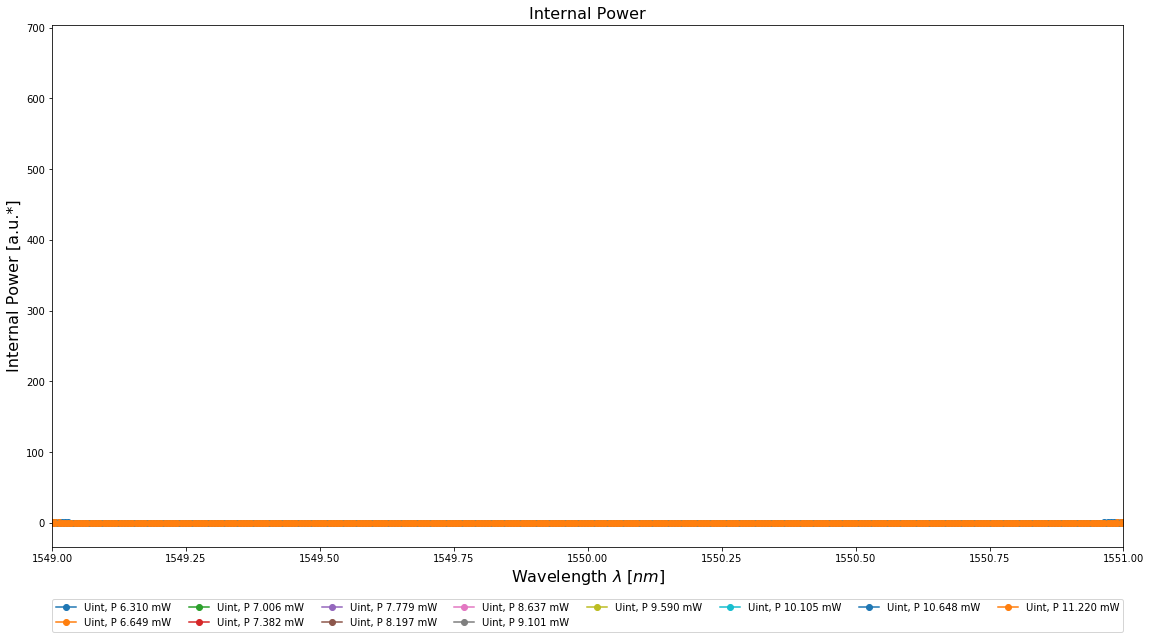

In [14]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

#ax1.set_ylim([5e3, 7.5e4])
ax1.set_xlim([1549, 1551])

for E_i in range(E_size):
    #if E_i <= 3:
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0], label='Uint, P %.3f mW'%E_range[E_i]**2, ls='-', marker='o')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,1], label='Uint', ls='--')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,2], label='Uint', ls='-.')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Us'][:,E_i,0], label='Uint', ls=':')
        
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0]-np.mean(d['Ut'][:,E_i,0]), label='Uint, P %.3f'%E_range[E_i]**2 ) 
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['Us'][:,E_i,0])**2, label='Us, P %.3fmW'%E_range[E_i]**2)

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

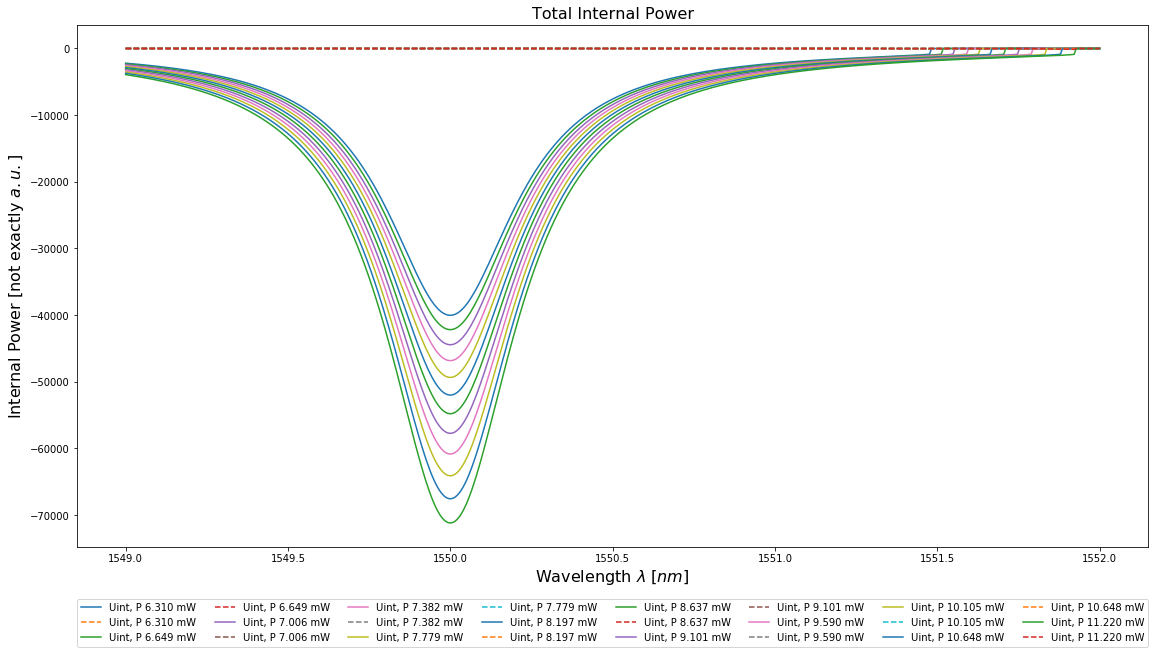

In [15]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])

for E_i in range(E_size):
    #if E_i <= 3:
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0]-d['Ut'][:,E_i,2], label='Uint, P %.3f mW'%E_range[E_i]**2)
        ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,1]-d['Ut'][:,E_i,3], label='Uint, P %.3f mW'%E_range[E_i]**2, ls='--')

ax1.set_title( r'Total Internal Power', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -0.05, 1., -0.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

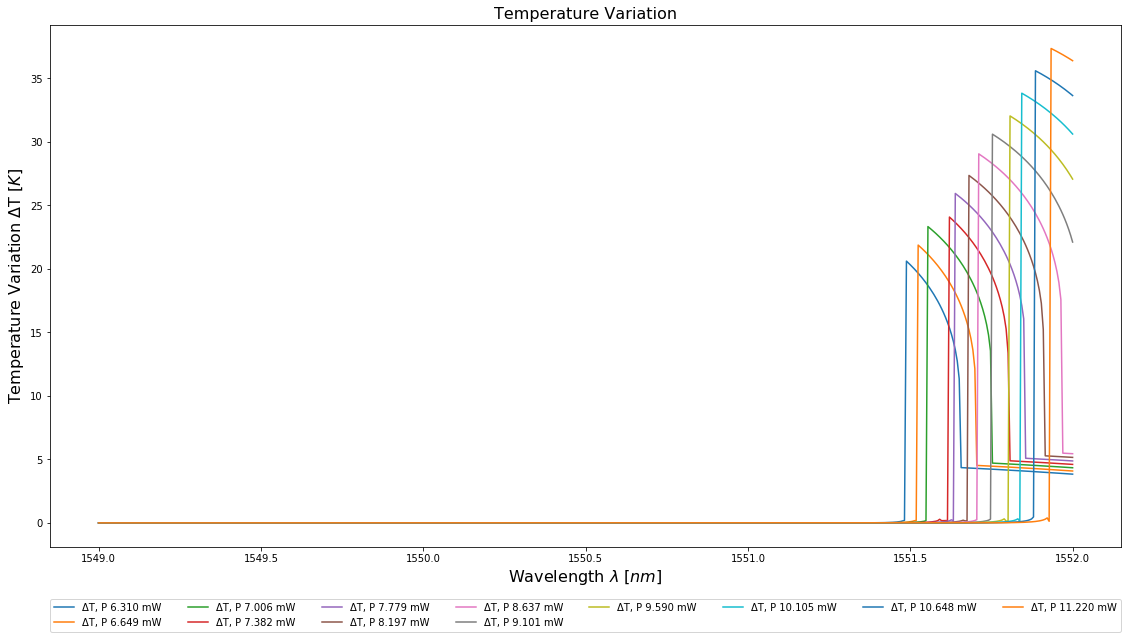

In [12]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])  

if 0:
    for E_i in range(E_size):
        ax1.plot(1e9*f2w(ω_range*ω0,), d['ΔN'][:,E_i,0], label='ΔN, P %.3f mW'%E_range[E_i]**2)
    ax1.set_title( r'Population Variation', fontsize=16)
    ax1.set_ylabel(r'Population Variation ΔN $[a.u.]$', fontsize=16)

if 1:
    for E_i in range(E_size):
        ax1.plot(1e9*f2w(ω_range*ω0,), d['ΔT'][:,E_i,0], label='ΔT, P %.3f mW'%E_range[E_i]**2)
    ax1.set_title( r'Temperature Variation', fontsize=16)
    ax1.set_ylabel(r'Temperature Variation ΔT $[K]$', fontsize=16)

if 0:
    ax2 = ax1.twinx()
    for E_i in range(E_size):
        ax2.plot(1e9*f2w(ω_range*ω0,), np.real(d['Δω'][:,E_i,0])/ω0, label='RE[Δω], P %.3f mW'%E_range[E_i]**2)
        ax2.plot(1e9*f2w(ω_range*ω0,), np.imag(d['Δω'][:,E_i,0])/ω0, label='IM[Δω], P %.3f mW'%E_range[E_i]**2, ls='--')
    #ax2.set_title( r'Resonance Wavelength Variation', fontsize=16)
    ax2.set_title( r'Physical Quantities Variation', fontsize=16)
    ax2.set_ylabel(r'Resonance Wavelength Variation Δω $[nm]$', fontsize=16)
    
#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

In [8]:
vectω = []
vectP = []

for E_i in range(E_size):
    indx = np.where( np.abs(d['Ut'][:,E_i,0])**2==max(np.abs(d['Ut'][:,E_i,0])**2) )
    tmp = f2w(ω_range[indx]*ω0)
    vectω.append(tmp[0])
    tmp = np.abs(d['Ut'][indx,E_i,0])**2
    vectP.append(tmp[0][0])
del indx, tmp
vectω = np.array(vectω)
vectP = np.array(vectP)
#print(vectω)
#print(vectP)

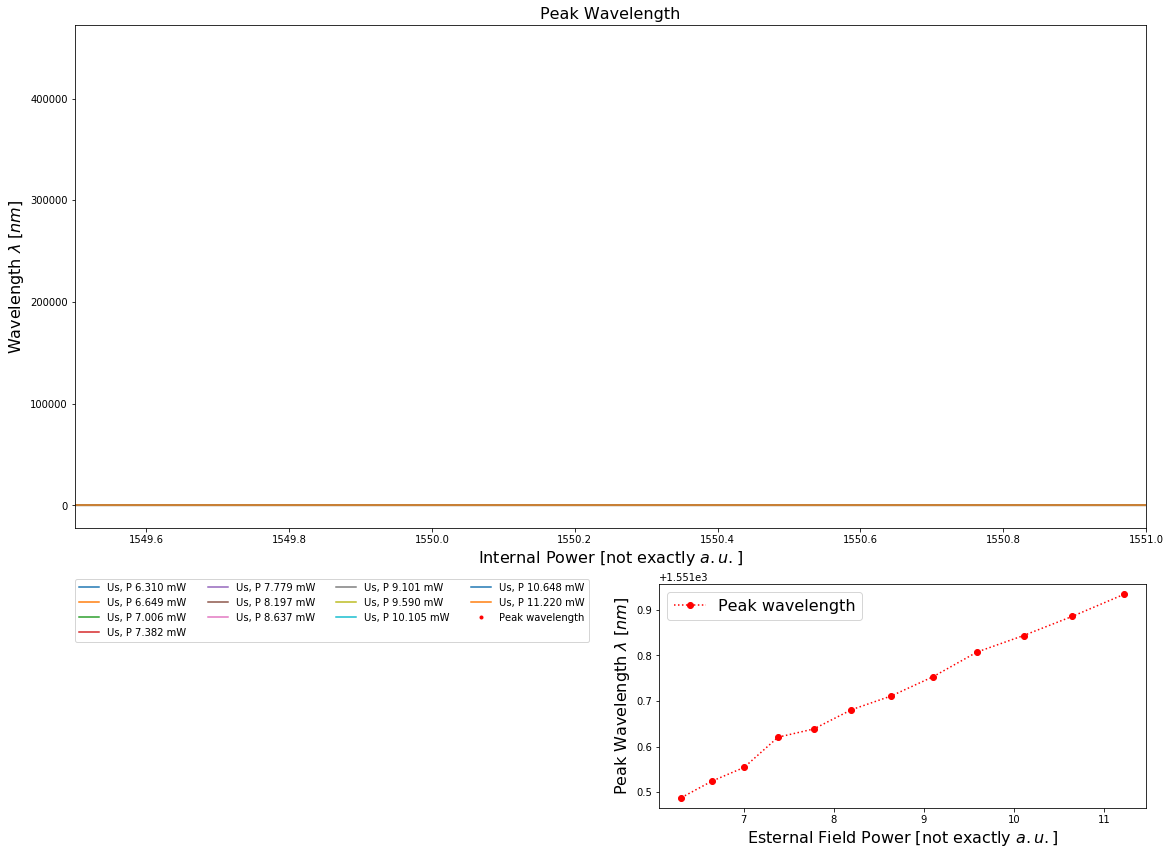

In [9]:
fig = plt.figure(figsize=(3*6.4, 3*4.8)) # default = 6.4, 4.8
gs = gridspec.GridSpec(3, 2)
gs.update(hspace=0.25)

# first graph
ax1 = plt.subplot(gs[0:2, :])

for E_i in range(E_size):
    ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['Ut'][:,E_i,0])**2, label='Us, P %.3f mW'%E_range[E_i]**2)

ax1.set_xlim([1549.5, 1551])

ax1.plot(np.array(vectω)*1.0e9, vectP, '.', label='Peak wavelength', color='red')

ax1.set_title( r'Peak Wavelength', fontsize=16)
ax1.set_xlabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, .48, -.05), loc=2, ncol=4, mode="expand", borderaxespad=0.)

# second graph
ax2 = plt.subplot(gs[2, 1])

ax2.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength', color='red')

ax2.set_ylabel(r'Peak Wavelength $\lambda$ $[nm]$', fontsize=16)
ax2.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

legend = ax2.legend(loc='upper left', fontsize=16)

plt.show()
plt.close()

In [10]:
p2 = np.poly1d(np.polyfit(E_range**2, vectω, 2))
p3 = np.poly1d(np.polyfit(E_range**2, vectω, 3))
p4 = np.poly1d(np.polyfit(E_range**2, vectω, 4))

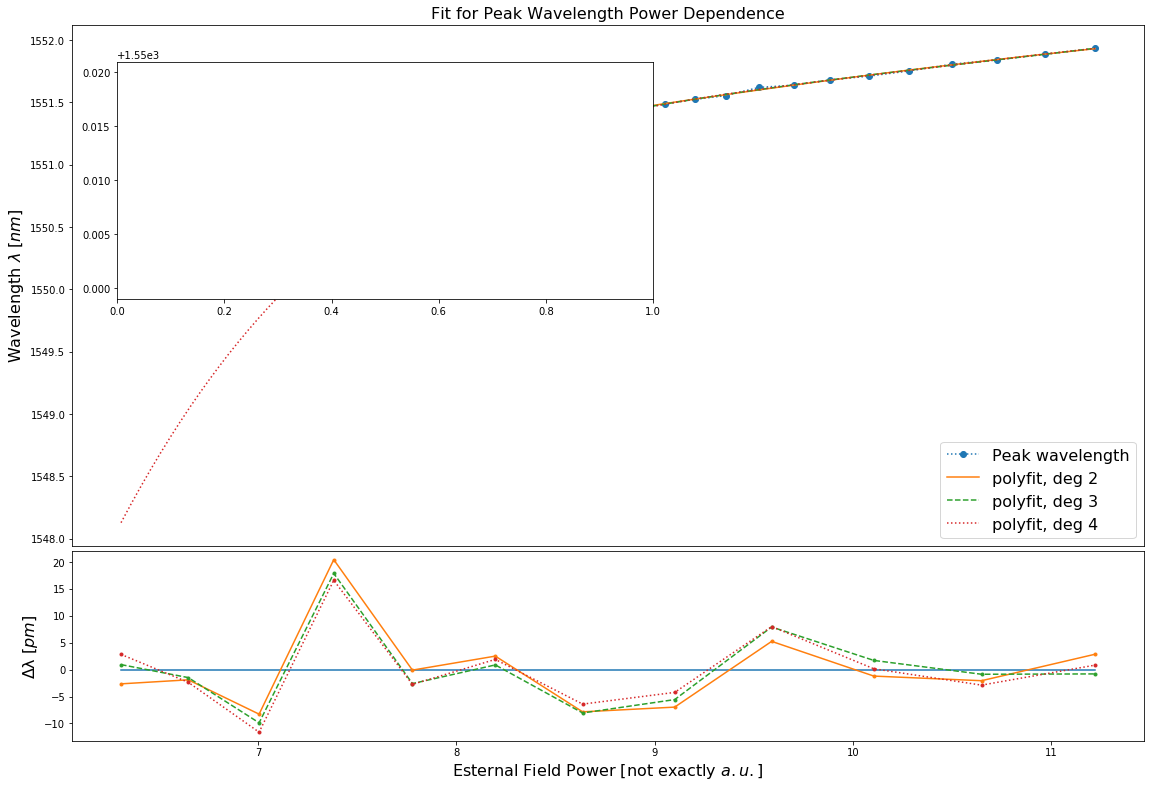

In [11]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

ax1.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength')
xp = np.linspace(.1, 10**(1.05), 200)
ax1.plot(xp, p2(xp)*1e9, '-', label='polyfit, deg 2')
ax1.plot(xp, p3(xp)*1e9, '--', label='polyfit, deg 3')
ax1.plot(xp, p4(xp)*1e9, ':', label='polyfit, deg 4')

ax1.set_title( r'Fit for Peak Wavelength Power Dependence', fontsize=16)
ax1.set_ylabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
#ax1.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

plt.xticks([])

legend = ax1.legend(loc='lower right', fontsize=16)#, bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(211)

ax2.set_xlim([0, 1])
ax2.set_ylim([1549.999, 1550.021])
plt.yticks(np.linspace(1550,1550.02,5))

ax2.plot(E_range**2, np.array(vectω)*1.0e9, marker='o', ls=':', label='Peak wavelength')
xp = np.linspace(.05, 1, 200)
ax2.plot(xp, p2(xp)*1e9, '-', label='polyfit, deg 2')
ax2.plot(xp, p3(xp)*1e9, '--', label='polyfit, deg 3')
ax2.plot(xp, p4(xp)*1e9, ':', label='polyfit, deg 4')

box = ax2.get_position()
ax2.set_position([box.x0*1.26, box.y0 *0.9, box.width * 0.5, box.height])

ax3 = fig.add_subplot(212)

box = ax3.get_position()
ax3.set_position([box.x0, -1.25 * box.y0, box.width, box.height*0.8])

ax3.plot(E_range**2, E_range*0, '-')
ax3.plot(E_range**2, (np.array(vectω)-p2(E_range**2)) * 1e12, '.-', label='Δλ polyfit, deg 2')
ax3.plot(E_range**2, (np.array(vectω)-p3(E_range**2)) * 1e12, '.--', label='Δλ polyfit, deg 3')
ax3.plot(E_range**2, (np.array(vectω)-p4(E_range**2)) * 1e12, '.:', label='Δλ polyfit, deg 4')

#ax1.set_title( r'Residuals', fontsize=16)
ax3.set_ylabel(r'Δλ $[pm]$', fontsize=16)
ax3.set_xlabel(r'Esternal Field Power $[$not exactly $a.u.]$', fontsize=16)

plt.show()
plt.close()